In [1]:
# Import libraries
'''
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
'''

# Pretty display for notebooks
'''
%matplotlib inline
'''

# Allows the use of display() for DataFrames
from IPython.display import display 

# Ignore the warnings
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
train = pd.read_csv("../asset/train.csv")
test = pd.read_csv("../asset/test.csv")
weather = pd.read_csv("../asset/weather.csv")
key = pd.read_csv("../asset/key.csv")
submission_example = pd.read_csv("../asset/sampleSubmission.csv")

# Success - Display the first record
print("Train data : ", train.shape)
print("Test  data : ", test.shape)
print("weather  data : ", weather.shape)
print("key  data : ", key.shape)
print("submission  data : ", submission_example.shape)

import pickle
import costum_functions as cf

slack_url = pickle.load(open('slackUrl.pickle', 'rb'))
slack_url

# 원본을 유지하기 위해서 카피
df_train = train.copy()
df_weather = weather.copy()
df_key = key.copy()
df_test = test.copy()

Train data :  (4617600, 4)
Test  data :  (526917, 3)
weather  data :  (20517, 20)
key  data :  (45, 2)
submission  data :  (526917, 2)


In [2]:
def isThereNoneData(df, percentage=60):
    """
        Missing data, Trace data의 개수정보를 받아서 만든 dataframe을 리턴한다.
        패러미터는 df만 받는다.(weather df에서만 M, T가 존재하므로 그 외에는 의미가 없다.)
    """
    columns = ["Column", "Row Count", "Missing Data", "M Data %", "Trace Data", "T Data %", "Bar Data", "B Data %"]
    li = list(df.columns)
    m_count_li = []
    t_count_li = []
    b_count_li = []    
    row_count_li = []
    m_percent_li = []
    t_percent_li = []
    b_percent_li = []
    for l in li:
        m_count = 0
        t_count = 0
        b_count = 0
        for i, contents in enumerate(df[l]):
            contents = str(contents)
            if(contents.strip() == "M"):
                m_count += 1
            if(contents.strip() == "T"):
                t_count += 1
            if(contents.strip() == "-"):
                b_count += 1            
        m_count_li.append(m_count)
        t_count_li.append(t_count)
        b_count_li.append(b_count)
        row_count_li.append(len(df[l]))
        m_percent_li.append(round(m_count/len(df[l])*100,2))
        t_percent_li.append(round(t_count/len(df[l])*100,2))
        b_percent_li.append(round(b_count/len(df[l])*100,2))
    result_df = pd.DataFrame({"Column" : li, "Row Count" : row_count_li,
                         "Missing Data" : m_count_li, "M Data %" : m_percent_li,
                         "Trace Data" : t_count_li, "T Data %": t_percent_li,
                         "Bar Data" : b_count_li, "B Data %" : b_percent_li}, columns=columns) 

    print("M Data over {}% : {}".format(percentage, list(result_df["Column"][result_df["M Data %"] >= percentage])))
    print("T Data over {}% : {}".format(percentage, list(result_df["Column"][result_df["T Data %"] >= percentage])))
    print("B Data over {}% : {}".format(percentage, list(result_df["Column"][result_df["B Data %"] >= percentage])))
#     print(result_df[result_df.loc["M Data %"]=="100.0%"].columns)
    return result_df

##### missing data 삭제 후 column간 상관관계 파악 : station 7
- M value row, - value row 모두 삭제
- T value 모두 0으로 변환

In [3]:
df_station_7 = df_weather[df_weather["station_nbr"]==7].reset_index(drop=True)
isThereNoneData(df_station_7)

M Data over 60% : ['depart']
T Data over 60% : []
B Data over 60% : ['sunrise', 'sunset']


,Column,Row Count,Missing Data,M Data %,Trace Data,T Data %,Bar Data,B Data %
0,station_nbr,1035,0,0.00,0,0.00,0,0.0
1,date,1035,0,0.00,0,0.00,0,0.0
2,tmax,1035,35,3.38,0,0.00,0,0.0
3,tmin,1035,34,3.29,0,0.00,0,0.0
4,tavg,1035,41,3.96,0,0.00,0,0.0
5,depart,1035,1035,100.00,0,0.00,0,0.0
6,dewpoint,1035,37,3.57,0,0.00,0,0.0
7,wetbulb,1035,42,4.06,0,0.00,0,0.0
8,heat,1035,41,3.96,0,0.00,0,0.0
9,cool,1035,41,3.96,0,0.00,0,0.0


In [5]:
df_station_7.drop("depart", axis=1, inplace=True) # 1번 경우에는 snowfall 컬럼 전체가 m 이므로 drop
df_station_7.drop("sunrise", axis=1, inplace=True) # 위와 동일
df_station_7.drop("sunset", axis=1, inplace=True) # 위와 동일
df_station_7_dropped_all = remove_m_row(df_station_7)
print("원래 station_6의 row 개수" + str(len(df_station_7)))
print("원래 전체 컬럼의 m value를 포함한 row를 날린 후 전체 개수" + str(len(df_station_7_dropped_all)))

원래 station_6의 row 개수1035
원래 전체 컬럼의 m value를 포함한 row를 날린 후 전체 개수935


In [6]:
def changeTypeToInt(a):
    temp = str(a).strip()
    if temp == 'M' or temp == '-':
        return np.nan
    else:
        return int(a)
    
def changeTypeToFloat(a):
    temp = str(a).strip()
    if temp == 'M' or temp == '-':
        return np.nan
    elif temp == 'T':
        return 0
    else:
        return float(a)
    
def remove_m_row(df, columns = []):
    """
        m_row를 제거할 data_frame 파일을 df 패러미터로 넣어준다.
        columns를 패러미터로 안넣어줄 경우에는 전체 컬럼의 m값을 날린다.
        columns를 넣어주는 경우에는 반드시 리스트로 넣어줄것!! 예:) ["tmax", "tmin"]
        그리고 처리된 df를 리턴하는 것이므로!! 원하는 변수명으로 받아줄 것
        예:) df_test = remove_m_row(df_weather, ["tmax", "tmin"])
    """
    result_df = df.copy()
    if len(columns) == 0:
        columns = result_df.columns
    cols_int = ["tmax", "tmin", "tavg", "dewpoint", "wetbulb", "heat", "cool", "sunrise", "sunset"]
    cols_float = ["snowfall", "preciptotal", "stnpressure", "sealevel", "depart", "resultspeed", "resultdir", "avgspeed"]
    for column in columns:
#         print(column)
        if column in cols_int:
            result_df[column] = result_df[column].apply(changeTypeToInt)
        elif column in cols_float:
            result_df[column] = result_df[column].apply(changeTypeToFloat)
    return result_df.dropna()

# weather = pd.read_csv("../asset/weather.csv") 테스트 용으로 추가해놓은 line입니다.

In [7]:
col_t = ["tmax", "tmin", "tavg"]
col_d = ["dewpoint", "wetbulb"]
col_h = ["heat", "cool", "sunrise", "sunset"]
col_s = ["snowfall", "preciptotal", "stnpressure", "sealevel"]
col_w = ["resultspeed", "avgspeed"] #, "resultdir"

In [8]:
col_t = ["tmax", "tmin", "tavg"]
df_station_7_only_dropped_t = df_station_7.copy()
df_station_7_only_dropped_t = remove_m_row(df_station_7, col_t)
print("원래 station_7의 row 개수" + str(len(df_station_7)))
print("원래 t관련 컬럼의 m value를 포함한 row를 날린 후 전체 개수" + str(len(df_station_7_only_dropped_t)))

원래 station_7의 row 개수1035
원래 t관련 컬럼의 m value를 포함한 row를 날린 후 전체 개수994


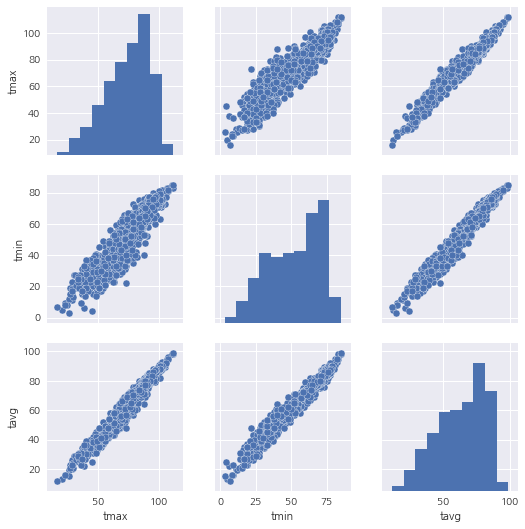

In [9]:
sns.pairplot(df_station_7_only_dropped_t[col_t])
plt.show()

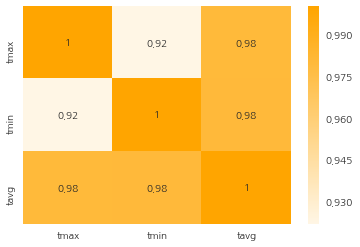

In [11]:
cmap = sns.light_palette("orange", as_cmap=True)
sns.heatmap(df_station_7_only_dropped_t[col_t].corr(), annot=True, cmap=cmap)
plt.show()

In [12]:
col_d = ["dewpoint", "wetbulb"]
df_station_7_only_dropped_d = df_station_7.copy()
df_station_7_only_dropped_d = remove_m_row(df_station_7, col_d)
print("원래 station_7의 row 개수" + str(len(df_station_7)))
print("원래 t관련 컬럼의 m value를 포함한 row를 날린 후 전체 개수" + str(len(df_station_7_only_dropped_d)))

원래 station_7의 row 개수1035
원래 t관련 컬럼의 m value를 포함한 row를 날린 후 전체 개수993


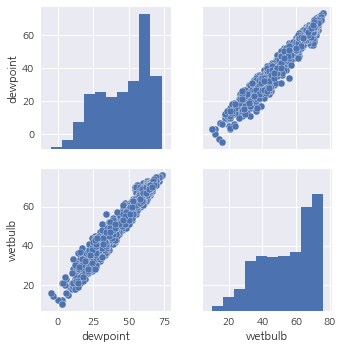

In [13]:
sns.pairplot(df_station_7_only_dropped_d[col_d])
plt.show()

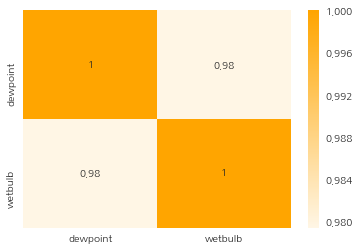

In [21]:
sns.heatmap(df_station_7_only_dropped_d[col_d].corr(), annot=True, cmap=cmap)
plt.show()

In [18]:
col_h = ["heat", "cool"]
df_station_7_only_dropped_h = df_station_7.copy()
df_station_7_only_dropped_h = remove_m_row(df_station_7, col_h)
print("원래 station_7의 row 개수" + str(len(df_station_7)))
print("원래 t관련 컬럼의 m value를 포함한 row를 날린 후 전체 개수" + str(len(df_station_7_only_dropped_h)))

원래 station_7의 row 개수1035
원래 t관련 컬럼의 m value를 포함한 row를 날린 후 전체 개수994


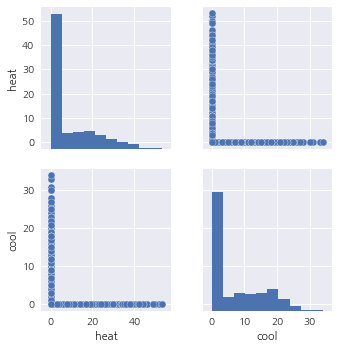

In [20]:
sns.pairplot(df_station_7_only_dropped_h[col_h])
plt.show()

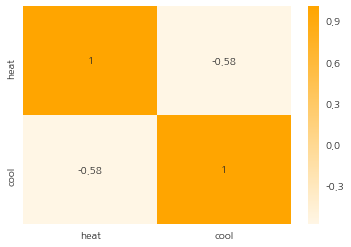

In [23]:
sns.heatmap(df_station_7_only_dropped_h[col_h].corr(), annot=True, cmap=cmap)
plt.show()

In [24]:
col_s = ["snowfall", "preciptotal", "stnpressure", "sealevel"]
df_station_7_only_dropped_s = df_station_7.copy()
df_station_7_only_dropped_s = remove_m_row(df_station_7, col_s)
print("원래 station_7의 row 개수" + str(len(df_station_7)))
print("원래 t관련 컬럼의 m value를 포함한 row를 날린 후 전체 개수" + str(len(df_station_7_only_dropped_s)))

원래 station_7의 row 개수1035
원래 t관련 컬럼의 m value를 포함한 row를 날린 후 전체 개수946


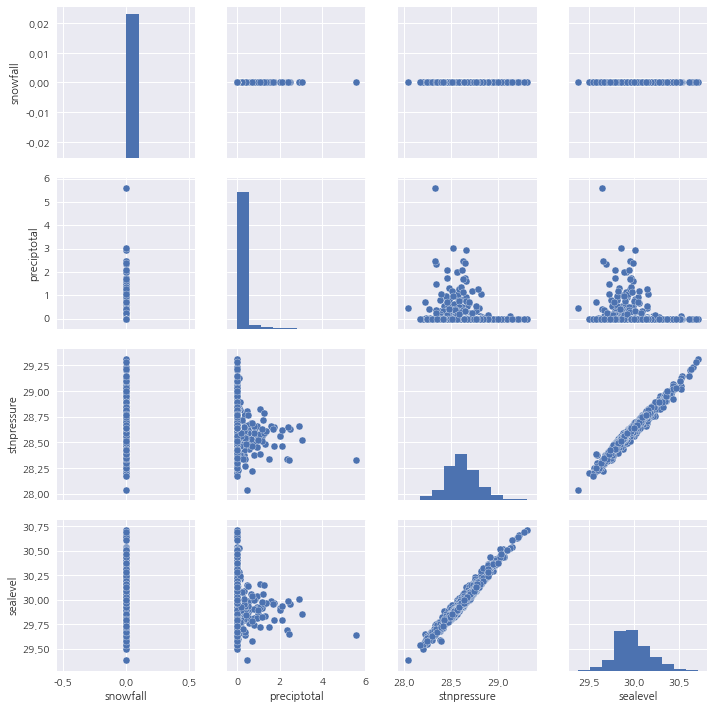

In [32]:
sns.pairplot(df_station_7_only_dropped_s[col_s])
plt.show()

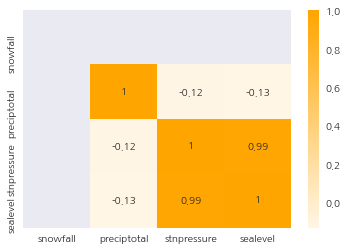

In [27]:
sns.heatmap(df_station_7_only_dropped_s[col_s].corr(), annot=True, cmap=cmap)
plt.show()

In [28]:
col_w = ["resultspeed", "avgspeed"] #, "resultdir"
df_station_7_only_dropped_w = df_station_7.copy()
df_station_7_only_dropped_w = remove_m_row(df_station_7, col_w)
print("원래 station_7의 row 개수" + str(len(df_station_7)))
print("원래 t관련 컬럼의 m value를 포함한 row를 날린 후 전체 개수" + str(len(df_station_7_only_dropped_w)))

원래 station_7의 row 개수1035
원래 t관련 컬럼의 m value를 포함한 row를 날린 후 전체 개수1029


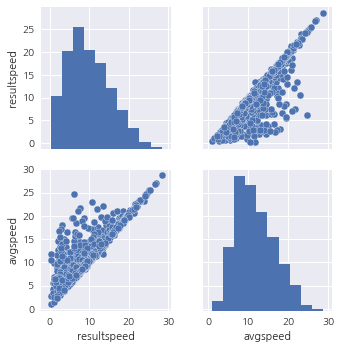

In [29]:
sns.pairplot(df_station_7_only_dropped_w[col_w])
plt.show()

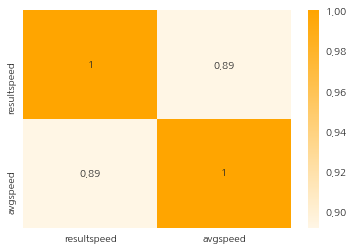

In [31]:
sns.heatmap(df_station_7_only_dropped_w[col_w].corr(), annot=True, cmap=cmap)
plt.show()